# Battery Remaining Useful Life (RUL) Prediction with Random Forest
Bertujuan untuk memprediksi Sisa Umur Pakai (Remaining Useful Life/RUL) baterai menggunakan model Random Forest. Proses yang akan kita lakukan:

1. Data Loading and Initial Cleaning
2. Exploratory Data Analysis (condensed)
3. Feature Selection and Preprocessing (including outlier handling and transformations)
4. Model Training
5. Model Evaluation
6. Feature Importance
7. Model Export

# 1. Import Libraries

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
from sklearn.model_selection import GridSearchCV, KFold

Mengimport setiap library yang dibutuhkan

In [159]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 2. Load Data

In [160]:
try:
    df = pd.read_csv("../input/battery-remaining-useful-life-rul/Battery_RUL.csv")
except FileNotFoundError:
    print("Dataset file not found at ../input/battery-remaining-useful-life-rul/Battery_RUL.csv. Please check the path.")
    print("Attempting to load from local 'Battery_RUL.csv'...")
    try:
        df = pd.read_csv("Battery_RUL.csv")
        print("Successfully loaded 'Battery_RUL.csv' from local directory.")
    except FileNotFoundError:
        print("Local 'Battery_RUL.csv' not found. Please ensure the file is in the correct location.")
        # Exit or raise error if file is critical
        raise

Dataset file not found at ../input/battery-remaining-useful-life-rul/Battery_RUL.csv. Please check the path.
Attempting to load from local 'Battery_RUL.csv'...
Successfully loaded 'Battery_RUL.csv' from local directory.


Load dataset agar dapat diproses lebih lanjut

## 3. Initial Data Preparation

In [161]:
print("Original DataFrame shape:", df.shape)

Original DataFrame shape: (15064, 9)


Agar kita dapat mengetahui shape dari dataset yang kita ambil

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


Dataset memiliki total 15.064 row data.
Ada 9 columns atau fitur di dataset ini.
Semua kolom terlihat lengkap (tidak ada missing values) dengan jumlah 15064 non-null di setiap kolom. 

In [163]:
print("\nOriginal DataFrame head:\n", df.head())


Original DataFrame head:
    Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
0          1.0             2595.30             1151.488500   
1          2.0             7408.64             1172.512500   
2          3.0             7393.76             1112.992000   
3          4.0             7385.50             1080.320667   
4          6.0            65022.75            29813.487000   

   Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
0                      3.670                    3.211           5460.001   
1                      4.246                    3.220           5508.992   
2                      4.249                    3.224           5508.993   
3                      4.250                    3.225           5502.016   
4                      4.290                    3.398           5480.992   

   Time constant current (s)  Charging time (s)   RUL  
0                    6755.01           10777.82  1112  
1                    6762.02   

Melihat beberapa baris pertama dataset kita menggunakan df.head(). Tujuan utamanya mendapatkan gambaran awal tentang isi data, seperti contoh nilai di setiap kolom dan formatnya. Dari sini, kita bisa intip ada kolom Cycle_Index, Discharge Time (s), berbagai metrik tegangan dan waktu, sampai akhirnya kolom RUL yang jadi target. Ini penting, sebelum melakukan analisis.

In [164]:
print("\nOriginal DataFrame describe:\n", df.describe())


Original DataFrame describe:
         Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
count  15064.000000        15064.000000            15064.000000   
mean     556.155005         4581.273960             1239.784672   
std      322.378480        33144.012077            15039.589269   
min        1.000000            8.690000          -397645.908000   
25%      271.000000         1169.310000              319.600000   
50%      560.000000         1557.250000              439.239471   
75%      833.000000         1908.000000              600.000000   
max     1134.000000       958320.370000           406703.768000   

       Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
count               15064.000000             15064.000000       15064.000000   
mean                    3.908176                 3.577904        3768.336171   
std                     0.091003                 0.123695        9129.552477   
min                     3.043000             

Dari output df.describe(), kita bisa perhatikan beberapa hal untuk setiap kolom:

-Semua kolom memiliki 15.064 entri, yang mengkonfirmasi tidak ada missing values di data numerik.

-Menunjukkan seberapa tersebar data dari nilai rata-ratanya. Nilai std yang besar, seperti pada Discharge Time (s) (sekitar 4581) atau Decrement 3.6-3.4V (s) (sekitar 1239), mengindikasikan sebaran data yang lebar.

-Pada min dan max terlihat ada nilai yang aneh atau tidak masuk akal di sini (misalnya, nilai negatif untuk waktu atau tegangan yang seharusnya tidak ada).

-Terdapat beberapa kolom yang memiliki nilai min yang sangat kecil atau bahkan negatif, seperti Decrement 3.6-3.4V (s) (-397645.9) atau Time at 4.15V (s) (-113.584), yang perlu kita perhatikan. Ini bisa jadi indikasi adanya outlier atau data yang kurang valid, yang nantinya perlu ditangani.

-Jika nilai mean dan median jauh berbeda, ini bisa jadi indikasi distribusi data yang miring (skewed). Misalnya, pada Decrement 3.6-3.4V (s), mean sekitar 1239 sedangkan median hanya 439, ini jelas menunjukkan distribusi yang miring ke kanan. Begitu juga dengan Time at 4.15V (s) atau Time constant current (s).


KESIMPULAN:

-Dari output ini, kita bisa melihat bahwa meskipun tidak ada missing values, beberapa kolom memiliki distribusi yang sangat miring (terlihat dari perbedaan jauh antara mean dan median serta nilai std yang tinggi). Selain itu, ada potensi outlier di beberapa kolom seperti Decrement 3.6-3.4V (s) dan Time at 4.15V (s) karena adanya nilai minimum yang ekstrem atau negatif. Ini adalah informasi penting yang akan menjadi pertimbangan kita saat melakukan preprocessing data, misalnya dengan menggunakan RobustScaler atau Power Transform untuk menangani data yang miring dan outlier tersebut.



In [165]:
if 'Cycle_Index' in df.columns:
    df.drop(columns='Cycle_Index', inplace=True)
    print("\nDropped 'Cycle_Index' column.")


Dropped 'Cycle_Index' column.


Pada tahapan ini, kita menghapus kolom 'Cycle_Index' dari dataset. Column ini dihapus karena berpotensi data leakage dan kemungkinan berkorelasi sempurna dengan target 'RUL', yang dapat membuat model kita terlihat bagus di awal tapi ternyata aslinya buruk. Dengan membuang column ini, dapat dipastikan model akan belajar dari fitur yang benar-benar relevan dan tidak ada "bocoran" informasi, jadi prediksinya nanti lebih akurat.



In [166]:
df.drop(index=15063, inplace=True)
print("Dropped row with index 15063.")

print("\nDataFrame shape after initial drops:", df.shape)

Dropped row with index 15063.

DataFrame shape after initial drops: (15063, 8)


Row terakhir dihapus karena baris tersebut diidentifikasi sebagai baris ringkasan atau total, bukan data aktual yang dapat mengurangi performa model.



In [167]:
original_cols = df.columns.tolist()

In [168]:
if 'RUL' in original_cols:
    original_features = [col for col in original_cols if col != 'RUL']
    new_feature_labels = [f'F{i+1}' for i in range(len(original_features))]
    new_col_labels = new_feature_labels + ['RUL']
    
    if len(original_cols) == len(new_col_labels):
        df_column_dict = dict(zip(original_cols, new_col_labels))
        df.rename(columns=df_column_dict, inplace=True)
        print("\nColumns renamed:")
        print(df_column_dict)
    else:
        print("\nColumn length mismatch. Skipping renaming.")
else:
    print("\n'RUL' column not found. Skipping renaming based on RUL.")


Columns renamed:
{'Discharge Time (s)': 'F1', 'Decrement 3.6-3.4V (s)': 'F2', 'Max. Voltage Dischar. (V)': 'F3', 'Min. Voltage Charg. (V)': 'F4', 'Time at 4.15V (s)': 'F5', 'Time constant current (s)': 'F6', 'Charging time (s)': 'F7', 'RUL': 'RUL'}


Untuk mempermudah penanganan data, kita melakukan penamaan ulang kolom-kolom fitur. Tujuan utamanya adalah memastikan kolom 'RUL' tetap menjadi kolom terakhir dan semua fitur lainnya diberi nama generik seperti 'F1', 'F2', 'F3', dan seterusnya. Setelah proses ini, setiap column di dataset akan memiliki nama yang lebih terstruktur, seperti Discharge Time (s) menjadi 'F1', Decrement 3.6-3.4V (s) menjadi 'F2', dan begitu seterusnya hingga 'RUL' di akhir. RUL tidak diubah karena mempermudah kami dalam menetapkan RUL sebagai target column.

In [169]:
print("\nDataFrame head after renaming:\n", df.head())


DataFrame head after renaming:
          F1            F2     F3     F4        F5        F6        F7   RUL
0   2595.30   1151.488500  3.670  3.211  5460.001   6755.01  10777.82  1112
1   7408.64   1172.512500  4.246  3.220  5508.992   6762.02  10500.35  1111
2   7393.76   1112.992000  4.249  3.224  5508.993   6762.02  10420.38  1110
3   7385.50   1080.320667  4.250  3.225  5502.016   6762.02  10322.81  1109
4  65022.75  29813.487000  4.290  3.398  5480.992  53213.54  56699.65  1107


Handle Duplicates

In [170]:
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
rows_after_duplicates = df.shape[0]
print(f"\nDropped {initial_rows - rows_after_duplicates} duplicate rows.")
print(f"DataFrame shape after dropping duplicates: {df.shape}")


Dropped 39 duplicate rows.
DataFrame shape after dropping duplicates: (15024, 8)


Menghilangkan data yang duplikat

Handle Negative Values

In [171]:
time_columns = []
if 'F1' in df.columns: time_columns.extend(['F1', 'F2', 'F5', 'F6', 'F7']) 

valid_time_columns = [col for col in time_columns if col in df.columns]

if valid_time_columns:
    rows_before_neg_filter = df.shape[0]
    for col in valid_time_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') 
    df.dropna(subset=valid_time_columns, inplace=True) 

    df = df[(df[valid_time_columns] >= 0).all(axis=1)]
    rows_after_neg_filter = df.shape[0]
    print(f"\nDropped {rows_before_neg_filter - rows_after_neg_filter} rows with negative values in time columns {valid_time_columns}.")
    print(f"DataFrame shape after handling negative time values: {df.shape}")
else:
    print("\nSkipping negative time value handling as relevant F-columns are not present (check renaming step).")


Dropped 33 rows with negative values in time columns ['F1', 'F2', 'F5', 'F6', 'F7'].
DataFrame shape after handling negative time values: (14991, 8)


Langkah preprocessing ini penting untuk menjaga kualitas dan keandalan dari dataset-nya. Data negatif perlu dihapus karena secara logis tidak merepresentasikan nilai yang valid atau mungkin mengindikasikan error dalam pengukuran/pengumpulan data. Keberadaan data negatif pada fitur yang seharusnya positif (misalnya, nilai sensor, durasi, atau jumlah) dapat mengakibatkan bias pada model prediksi, performa model yang kurang optimal, dan interpretasi hasil yang keliru, karena model akan belajar dari pola data yang tidak realistis dan tidak konsisten dengan domain masalah yang ada.


## 4. Exploratory Data Analysis


DataFrame describe (post-cleaning):
                   F1             F2            F3            F4  \
count   14991.000000   14991.000000  14991.000000  14991.000000   
mean     4229.206765    1435.772970      3.907896      3.577714   
std     31465.065102   13763.906517      0.089842      0.122218   
min         8.690000      31.168831      3.043000      3.022000   
25%      1171.670000     320.666667      3.846000      3.488000   
50%      1557.500000     440.000000      3.906000      3.573000   
75%      1908.000000     601.210500      3.972000      3.663000   
max    958320.370000  406703.768000      4.363000      4.300000   

                  F5             F6             F7           RUL  
count   14991.000000   14991.000000   14991.000000  14991.000000  
mean     3681.977745    5290.314287    9900.930998    554.978587  
std      8821.961146   24095.322918   25446.019660    322.154045  
min        14.052000       5.980000       5.980000      0.000000  
25%      1836.343500   

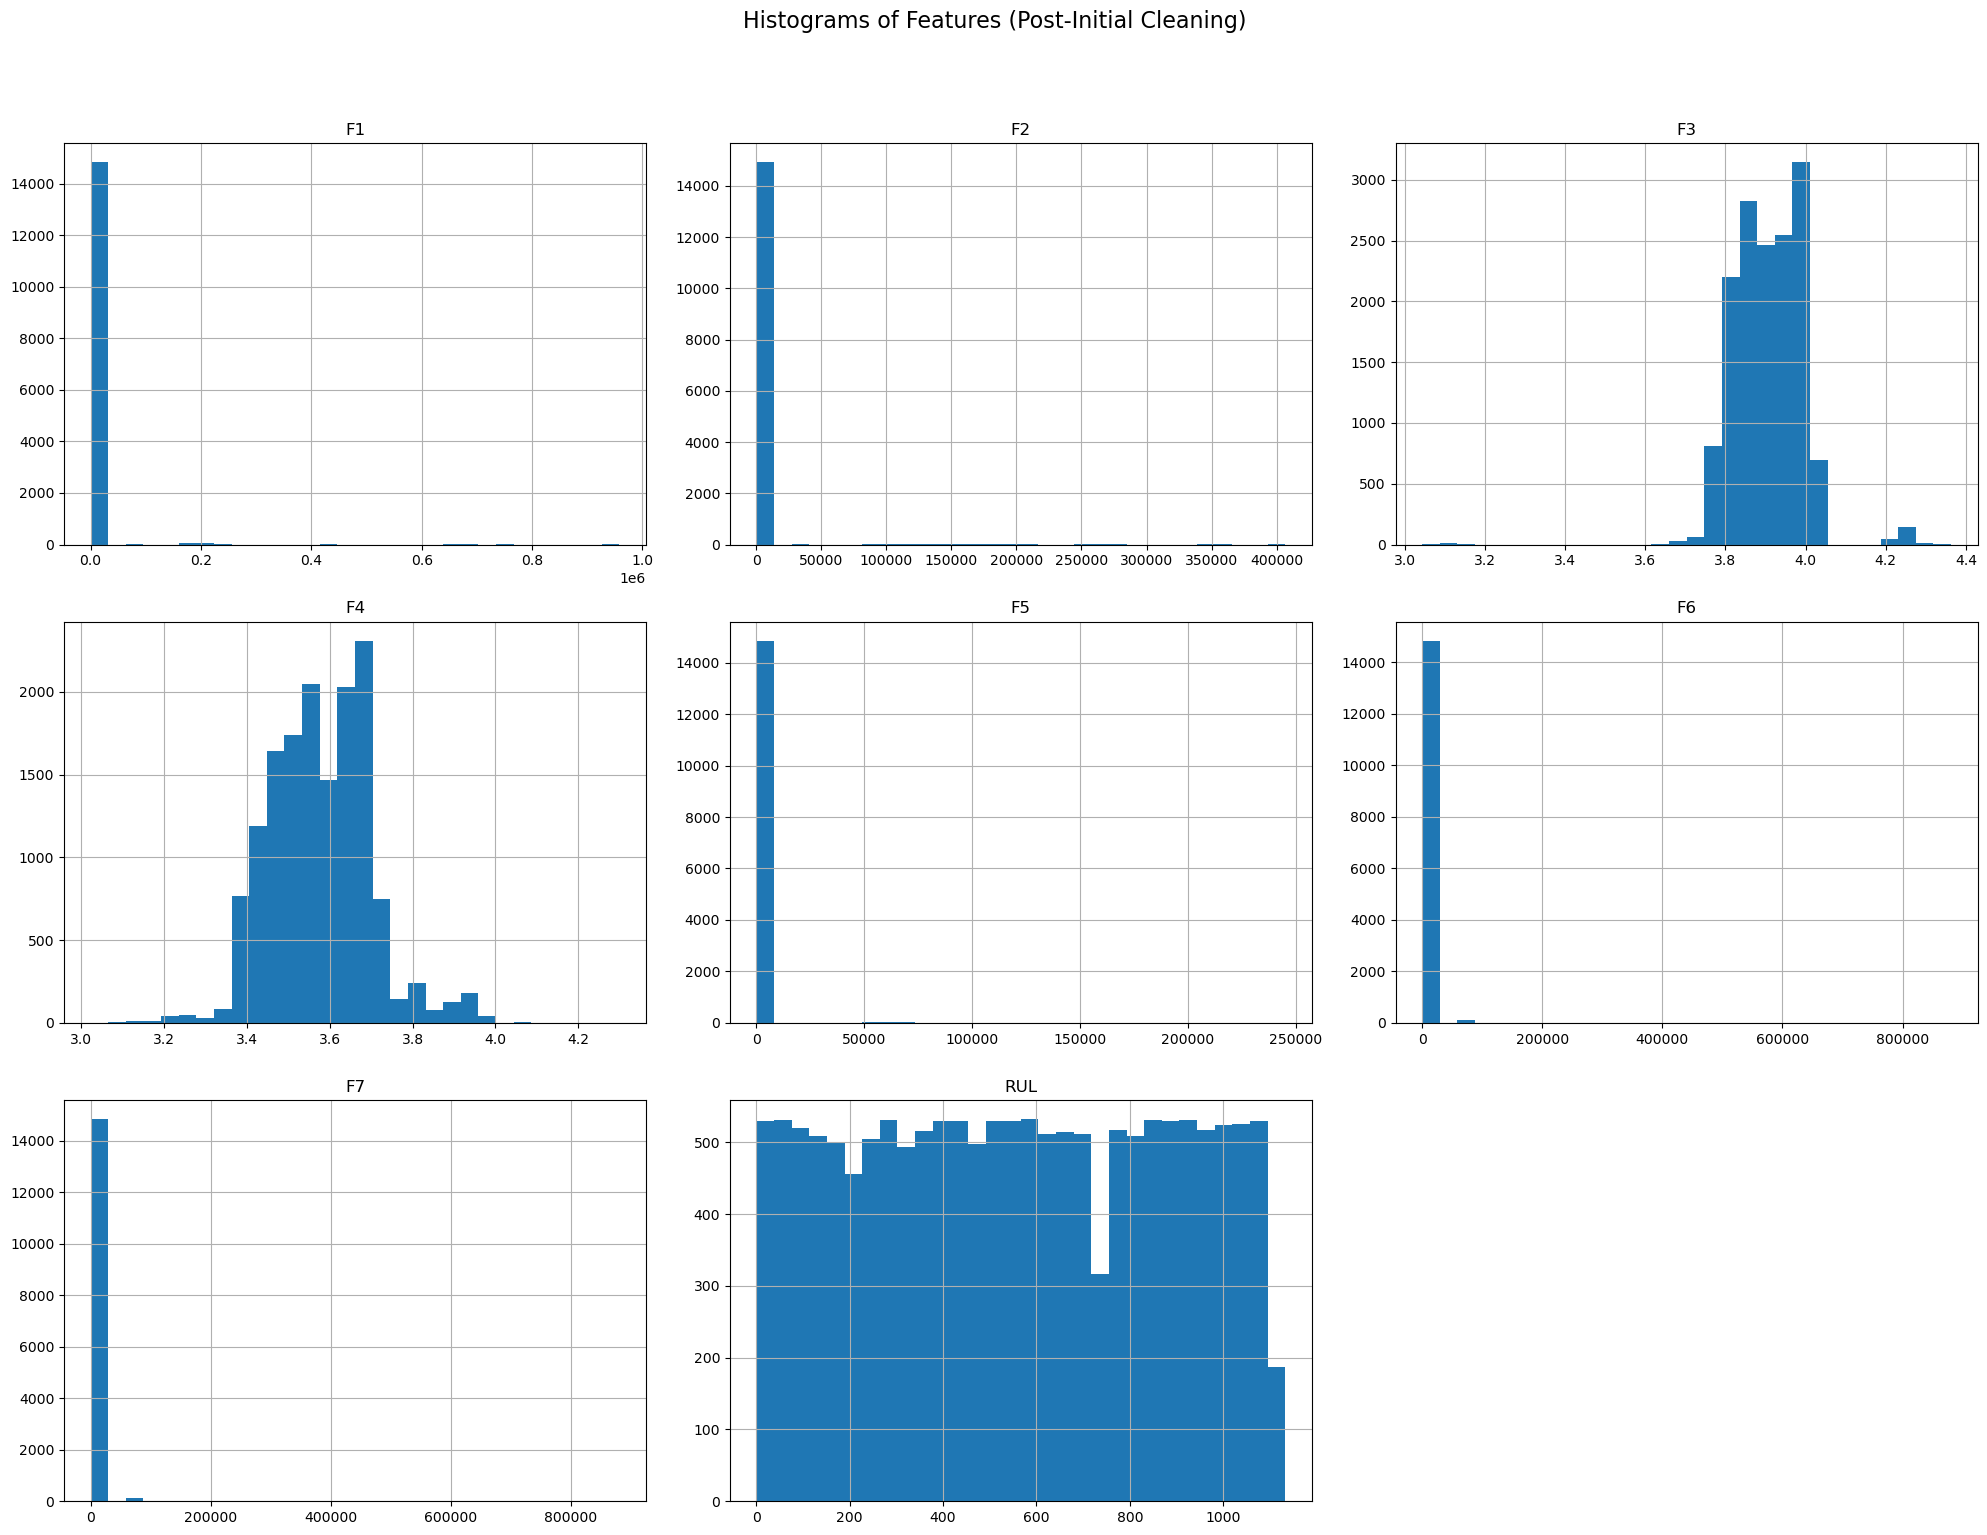

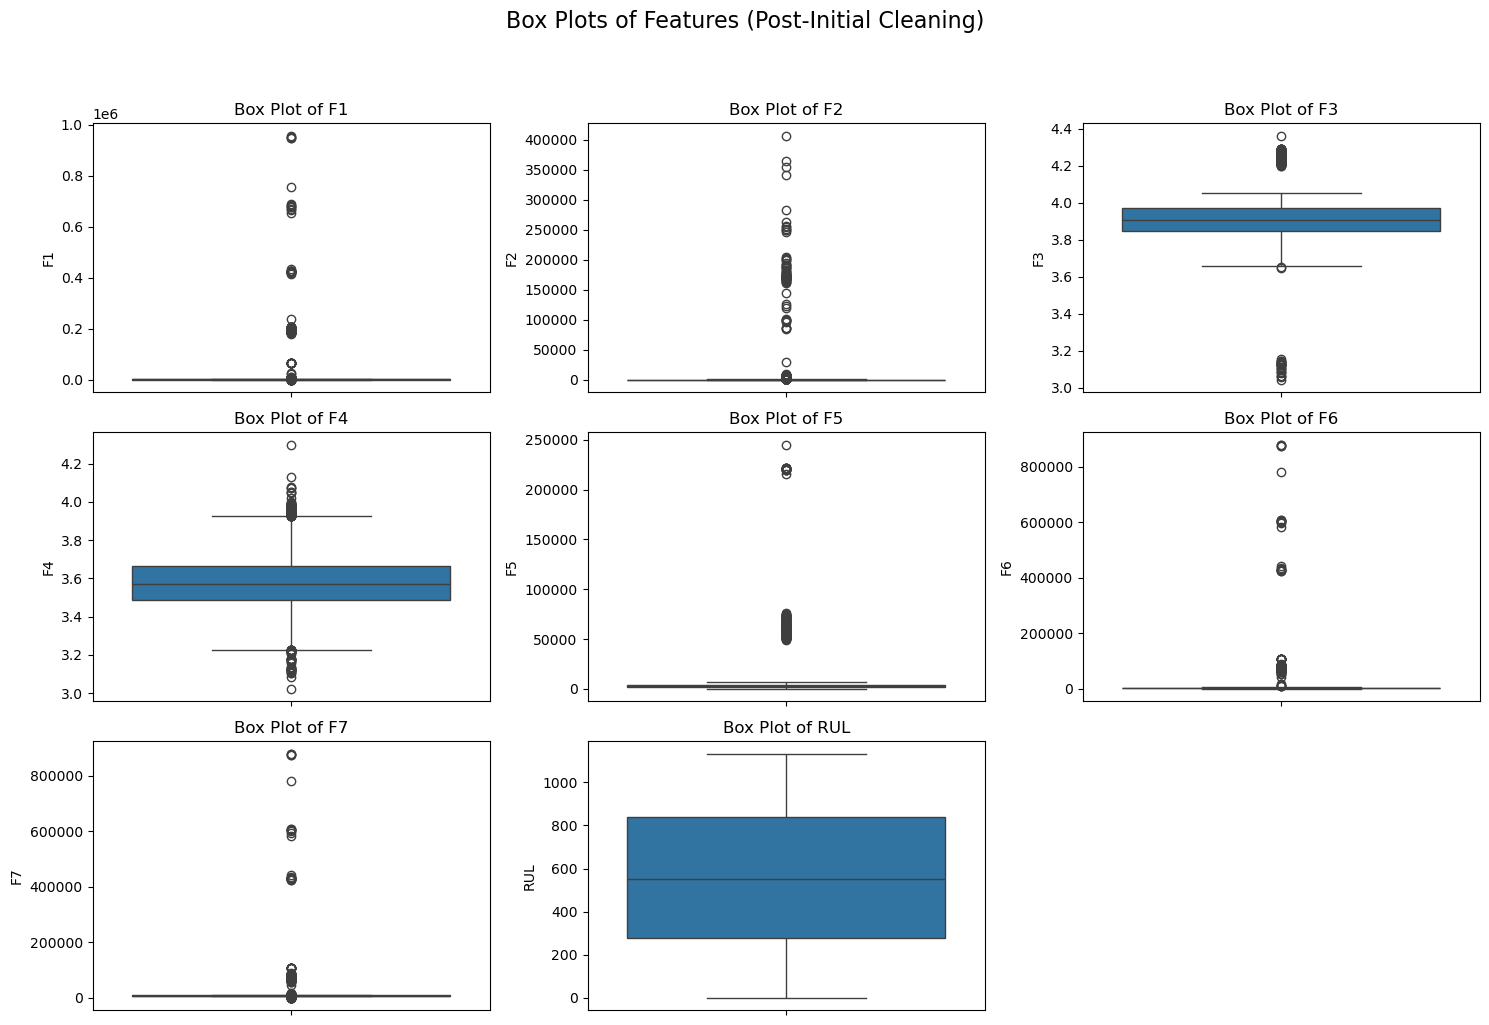

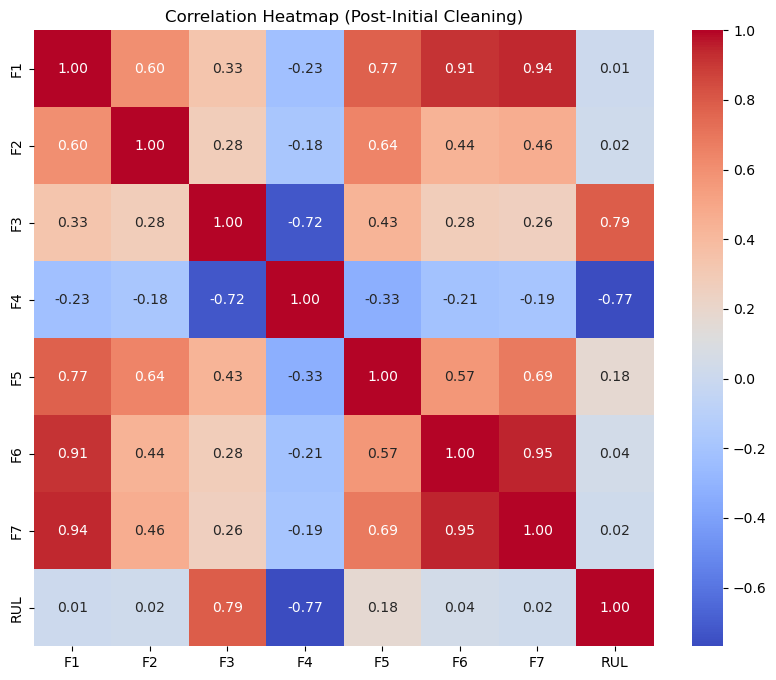

In [172]:
if not df.empty:
    print("\nDataFrame describe (post-cleaning):\n", df.describe())
    df.hist(bins=30, figsize=(20, 15), layout=(-1, 3))
    plt.suptitle("Histograms of Features (Post-Initial Cleaning)", y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


    if len(df.columns) > 1 :
        num_cols_for_boxplot = min(len(df.columns), 9) # Limit to 9 plots for readability
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(df.columns[:num_cols_for_boxplot]):
            plt.subplot(3, 3, i + 1)
            sns.boxplot(y=df[col])
            plt.title(f"Box Plot of {col}")
        plt.suptitle("Box Plots of Features (Post-Initial Cleaning)", y=1.02, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()


    plt.figure(figsize=(10, 8))
    numeric_df_for_corr = df.select_dtypes(include=np.number)
    if not numeric_df_for_corr.empty:
        sns.heatmap(numeric_df_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap (Post-Initial Cleaning)')
        plt.show()
    else:
        print("No numeric columns found for correlation heatmap after cleaning.")
else:
    print("DataFrame is empty after initial cleaning. Cannot perform EDA.")


### Descriptive Statistics:
Dapat kita lihat bahwa semua kolom memiliki 14.991 entri, mengindikasikan tidak ada missing values setelah preprocessing awal. Namun, perhatian khusus perlu diberikan pada fitur F1, F2, F5, F6, dan F7. Nilai max yang sangat besar dan perbedaan yang signifikan antara mean dan median pada fitur-fitur ini menunjukkan distribusi data yang sangat miring (skewed) ke kanan. Ini akan mejadi perhatian penting untuk pengambilan keputusan dalam tahap preprocessing selanjutnya, terutama terkait normalisasi atau transformasi data. Sementara itu, fitur F3, F4, dan RUL menunjukkan rentang nilai yang lebih terkonsentrasi."

#### Histograms of Features:
Dari plot ini mengkonfirmasi apa yang telah kita amati dari statistik deskriptif. Fitur F1, F2, F5, F6, dan F7 jelas menunjukkan distribusi yang sangat miring ke kanan, dengan sebagian besar data terkonsentrasi pada nilai-nilai yang lebih kecil dan adanya 'ekor' panjang yang merepresentasikan nilai-nilai ekstrem. Di sisi lain, histogram untuk fitur F3 dan F4 menunjukkan distribusi yang jauh lebih simetris dan terpusat, meskipun masih ada beberapa data di bagian ekor yang menandakan potensi outlier. Histograms ini memberikan gambaran visual yang kuat mengenai karakteristik distribusi setiap fitur, yang akan sangat berguna dalam memahami seberapa 'baik' data tersebut sebelum modeling.

#### Box Plots of Features:
Seperti yang dilihat di histogram, fitur F1, F2, F5, F6, dan F7 menunjukkan keberadaan outlier yang sangat banyak, direpresentasikan oleh titik-titik di luar 'jangkar' (whiskers) box plot. Ini menegaskan bahwa ada banyak nilai ekstrem dalam data kita untuk fitur-fitur ini.

Namun, yang menarik perhatian adalah performa relatif dari fitur-fitur lain. Box plot untuk F3 dan F4 terlihat paling 'bersih' dibandingkan fitur lainnya, dengan distribusi yang lebih kompak dan jumlah outlier yang lebih sedikit. Meskipun masih ada outlier, pola distribusinya jauh lebih terkontrol. F5, meskipun masih memiliki banyak outlier, menunjukkan sedikit perbaikan dalam kepadatan data di sekitar median dibandingkan dengan F1, F2, F6, dan F7, yang tampak lebih 'menyebar' dengan outlier yang sangat ekstrem. 


Insight ini sangat penting karena menunjukkan bahwa F3 dan F4 secara memiliki karakteristik data yang lebih baik dan mungkin memerlukan penanganan outlier yang lebih minimal atau bahkan tidak ada dibandingkan fitur lainnya. Sementara F5, meskipun masih bermasalah dengan outlier, menunjukkan potensi yang sedikit lebih baik dibandingkan fitur-fitur yang sangat miring lainnya.

#### Correlation Heatmap:
Korelasi F3 dengan RUL adalah positif yang sangat kuat (0.79), dan F4 dengan RUL adalah negatif yang juga sangat kuat (-0.77). Ini adalah penemuan yang signifikan.  Semakin tinggi nilai F3, RUL cenderung semakin tinggi dan sebaliknya, semakin tinggi nilai F4, RUL cenderung semakin rendah. Ini mengindikasikan bahwa F3 dan F4 adalah prediktor yang sangat kuat dan relevan untuk RUL.

F5 menunjukkan potensi, meskipun tidak sekuat F3 dan F4, F5 memiliki korelasi positif yang cukup baik dengan RUL (0.18). Meskipun angkanya lebih kecil, dibandingkan dengan fitur F1, F2, F6, dan F7 yang korelasinya cenderung sangat lemah (mendekati 0.01-0.04), F5 jelas memiliki koneksi yang lebih nyata dengan RUL. Ini menempatkan F5 pada posisi yang sedikit lebih menonjol dan membuatnya menjadi kandidat yang layak dipertimbangkan.

#### Kesimpulan untuk Pemilihan Fitur:

Berdasarkan kombinasi analisis box plot yang menunjukkan distribusi yang lebih baik untuk F3 dan F4, serta korelasi yang sangat kuat dengan RUL pada heatmap, F3 (Max. Voltage Dischar. (V)) dan F4 (Min. Voltage Charg. (V)) adalah kandidat utama yang paling menjanjikan untuk pemilihan fitur. Mereka menunjukkan kualitas data yang relatif baik dan hubungan prediktif yang jelas dengan RUL.

Lebih lanjut, meskipun memiliki lebih banyak outlier dan distribusi yang miring, F5 (Time at 4.15V (s)) juga muncul sebagai kandidat yang patut dipertimbangkan karena korelasinya yang, meskipun tidak sekuat F3 dan F4, jauh lebih menonjol dibandingkan fitur F1, F2, F6, dan F7. Potensi korelasi F5 dengan RUL, meskipun kecil, tetap menjadikannya opsi yang menarik untuk diteliti lebih lanjut, terutama jika kita perlu menangkap nuansa hubungan yang mungkin tidak terdeteksi oleh F3 dan F4 saja. Oleh karena itu, untuk proses Feature Selection & Further Preprocessing, kami akan fokus pada F3, F4, dan F5 sebagai kandidat utama yang paling berpotensi untuk memprediksi RUL.

# 5. Feature Selection & Further Preprocessing
Berdasarkan insights dari EDA, fitur-fitur yang memiliki potensi sebagai fitur-fitur paling penting adalah:
- `F3` (Max. Voltage Dischar. (V))
- `F4` (Min. Voltage Charg. (V))
- `F5` (Time at 4.15V (s))

Dengan `RUL` sebagai target.

In [173]:
potential_features = ['F3', 'F4', 'F5']
target_col = 'RUL'

In [174]:
selected_features = [col for col in potential_features if col in df.columns]

Berdasarkan insight dari EDA sebelumnya, kita memilih F3, F4, dan F5 sebagai fitur-fitur penting yang akan digunakan untuk memprediksi 'RUL'. Ini adalah langkah kunci untuk fokus pada data yang paling relevan.

In [175]:
if not selected_features:
    print(f"Error: None of the potential features {potential_features} are in the DataFrame columns: {df.columns.tolist()}. Stopping.")
    df_model = pd.DataFrame() # Empty df to avoid later errors
else:
    print(f"\nSelected features for modeling: {selected_features}")
    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in DataFrame. Stopping.")
        # raise ValueError("Target column not found.")
        df_model = pd.DataFrame()
    else:
        df_model = df[selected_features + [target_col]].copy()
        print(f"Shape of df_model before outlier removal: {df_model.shape}")


Selected features for modeling: ['F3', 'F4', 'F5']
Shape of df_model before outlier removal: (14991, 4)


In [176]:
df_model.describe()

,F3,F4,F5,RUL
count,14991.000000,14991.000000,14991.000000,14991.000000
mean,3.907896,3.577714,3681.977745,554.978587
std,0.089842,0.122218,8821.961146,322.154045
min,3.043000,3.022000,14.052000,0.000000
25%,3.846000,3.488000,1836.343500,279.000000
50%,3.906000,3.573000,2930.359000,551.000000
75%,3.972000,3.663000,4083.567500,840.000000
max,4.363000,4.300000,245101.117000,1133.000000


Setelah fitur-fitur penting terpilih (F3, F4, F5), langkah selanjutnya adalah mempersiapkan dataframe khusus yang hanya berisi fitur-fitur terpilih dan kolom target ('RUL'). Kita bikin df_model ini supaya lebih fokus dan tidak membawa kolom lain yang tidak relevan saat proses pemodelan. Hasilnya, df_model kita sekarang berukuran (14991, 4), yang berarti kita punya 14991 row dengan 3 features dan 1 target yang siap untuk digunakan selanjutnya.

Outlier Handling for Selected Features using IQR

# Remove Outliers

In [177]:
if not df_model.empty:
    print("\nApplying IQR-based outlier removal to selected features...")
    for col in selected_features: # Iterate over F3, F4, F5
        if col in df_model.columns: # Ensure column exists
            Q1 = df_model[col].quantile(0.25)
            Q3 = df_model[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            rows_before = df_model.shape[0]
            df_model = df_model[(df_model[col] >= lower_bound) & (df_model[col] <= upper_bound)]
            rows_after = df_model.shape[0]
            print(f"  Feature '{col}': Removed {rows_before - rows_after} outliers. Shape is now {df_model.shape}")
        else:
            print(f"  Warning: Column {col} for outlier removal not found in df_model.")
    print(f"DataFrame shape after outlier removal: {df_model.shape}")
else:
    print("df_model is empty. Skipping outlier handling.")


Applying IQR-based outlier removal to selected features...
  Feature 'F3': Removed 232 outliers. Shape is now (14759, 4)
  Feature 'F4': Removed 230 outliers. Shape is now (14529, 4)
  Feature 'F5': Removed 0 outliers. Shape is now (14529, 4)
DataFrame shape after outlier removal: (14529, 4)


In [178]:
df_model.describe()

,F3,F4,F5,RUL
count,14529.000000,14529.000000,14529.000000,14529.000000
mean,3.906023,3.576597,2988.560969,557.505747
std,0.073229,0.108746,1221.026787,319.137944
min,3.674000,3.355000,471.906000,1.000000
25%,3.848000,3.491000,1859.803571,285.000000
50%,3.907000,3.573000,2936.218000,556.000000
75%,3.970000,3.661000,4058.320000,840.000000
max,4.053000,3.917000,6826.609250,1127.000000


Pada tahapan ini, kita berfokus pada penanganan outlier di dataset dengan menggunakan metode Interquartile Range (IQR). Tujuannya jelas, untuk membuang nilai-nilai ekstrem yang bisa mengganggu analisis dan performa model kita. Prosesnya cukup sistematis: untuk setiap fitur yang sudah kita targetkan ('F3', 'F4', dan 'F5'), kita hitung Q1, Q3, dan IQR lalu menetukan batas bawah dan atasnya. Setiap data yang nilainya jauh di luar batas ini akan otomatis teridentifikasi sebagai outlier dan dihapus. Dari hasil yang muncul, kita bisa tahu bahwa fitur 'F3' kehilangan 232 outlier dan 'F4' kehilangan 230 outlier, sedangkan 'F5' ternyata bersih dari outlier. Dengan begitu, dataset kita sekarang lebih rapi, ukurannya jadi (14529, 4), dan siap untuk tahap selanjutnya.

In [179]:
if df_model.empty or target_col not in df_model.columns or not selected_features:
    print("\nCannot proceed to model training due to missing data or features.")
else:
    X = df_model.drop(target_col, axis=1)
    y = df_model[target_col]
    print("\nShape of X (features):", X.shape)
    print("Shape of y (target):", y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("\nShape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)

    std_scale_features = [col for col in ['F3', 'F4'] if col in X_train.columns]
    power_transform_features = [col for col in ['F5'] if col in X_train.columns]
    
    transformers_list = []
    if std_scale_features:
        transformers_list.append(('std_scaler', StandardScaler(), std_scale_features))
    if power_transform_features:
        transformers_list.append(('power_transform', PowerTransformer(method='yeo-johnson'), power_transform_features))

    if not transformers_list:
        print("Warning: No features identified for scaling or transformation. Preprocessor will be empty.")
        preprocessor = 'passthrough' 
    else:
        preprocessor = ColumnTransformer(transformers=transformers_list, remainder='passthrough')



Shape of X (features): (14529, 3)
Shape of y (target): (14529,)

Shape of X_train: (11623, 3)
Shape of X_test: (2906, 3)


In [180]:
if not df_model.empty:
    try:
        df_model.to_csv('df_model_export.csv', index=False)
        print("\ndf_model successfully exported to df_model_export.csv")
    except Exception as e:
        print(f"\nError exporting df_model to CSV: {e}")
else:
    print("\nCannot export empty df_model to CSV.")


df_model successfully exported to df_model_export.csv


Setelah outlier dihilangkan, selanjutnya kita mempersiapkan data sebelum masuk ke model. Data tersebut kita split train (80) dan test (20) = (rasio 80:20). Selain itu, kita juga mendefinisikan fitur mana saja yang perlu di-scaling ('F3' dan 'F4' dengan StandardScaler karena metrik tegangan) dan mana yang perlu di-transform ('F5' dengan PowerTransformer karena distribusinya miring). Setelah itu kita gabungkan dalam ColumnTransformer, memastikan setiap fitur mendapatkan preprocessing yang tepat sebelum data masuk ke model.

# 6. Model Training (Random Forest)

In [181]:
if 'X_train' not in locals() or X_train.empty:
    print("\nTraining data (X_train) is not available or empty. Skipping model training.")
else:
    
    if not transformers_list: 
        print("No specific column transformers defined (transformers_list is empty). Applying StandardScaler to all features as a default.")
        model_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()), 
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5, oob_score=True))
        ])
    else: 
        print("Using defined ColumnTransformer for preprocessing.")
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5, oob_score=True))
        ])

    print("\nTraining Random Forest Regressor model...")
    model_pipeline.fit(X_train, y_train)
    print("Model training complete.")
    current_regressor = model_pipeline.named_steps['regressor']
    if hasattr(current_regressor, 'oob_score') and current_regressor.oob_score: 
        if hasattr(current_regressor, 'oob_score_'):
            print(f"OOB Score: {current_regressor.oob_score_:.4f}")
        else:
            print("OOB Score was set to True, but the oob_score_ attribute was not found.")

Using defined ColumnTransformer for preprocessing.

Training Random Forest Regressor model...
Model training complete.
OOB Score: 0.9882


Setelah selesai melakukan preprocessing dan data sudah siap untuk digunakan,
kita melakukan:


-Membangun sebuah pipeline model yang mengintegrasikan langkah preprocessing dengan model Random Forest. Ini penting agar semua langkah (dari scaling atau transformasi hingga prediksi) berjalan otomatis dan konsisten.

Setelah langkah preprocessing, barulah model DIjalankan. Kita atur n_estimators=100 (jumlah decision tree yang digunakan), random_state=42, max_depth=10 (untuk mencegah overfitting), min_samples_split=5, dan oob_score=True (untuk mengestimasi performa model tanpa perlu Cross Validation terpisah).


Proses Training Model:
-Pipeline model yang sudah disiapkan akan ditraining menggunakan train data. Proses ini akan membuat model belajar pola dari data untuk bisa melakukan prediksi.

Evaluasi OOB Score:
Setelah model selesai dilatih, kita akan melihat nilai OOB (Out-Of-Bag) Score. OOB Score ini sangat berguna di Random Forest karena memberikan estimasi performa model pada data yang tidak digunakan saat membangun setiap tree

Hasil:
Mendapatkan OOB Score sebesar 0.9882. Nilai ini menunjukkan bahwa model memiliki performa yang sangat baik dalam memprediksi Battery Remain Use Life berdasarkan data pelatihan, karena skor mendekati 1 menandakan prediksi yang sangat akurat.

# 7. Model Evaluation (Before Tuning)


Evaluating model performance...
Mean Absolute Error (MAE): 22.27
Mean Squared Error (MSE): 1158.75
Root Mean Squared Error (RMSE): 34.04
R-squared (R²): 0.9888


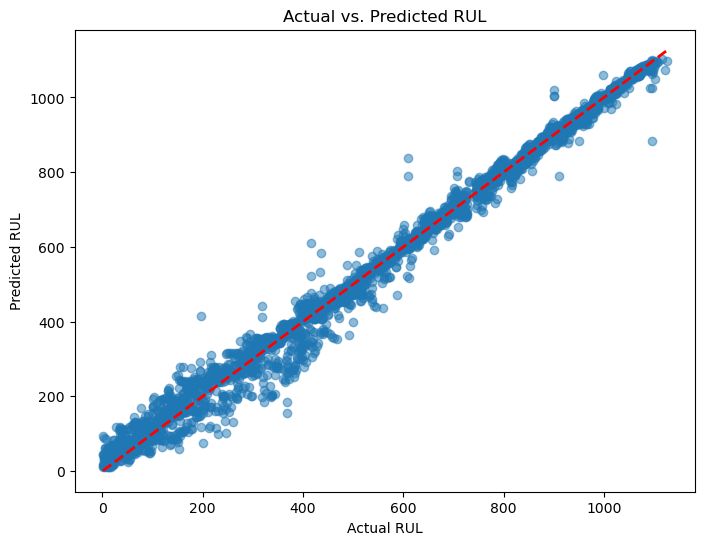

In [182]:
if 'model_pipeline' in locals() and 'X_test' in locals() and not X_test.empty:
    print("\nEvaluating model performance...")
    y_pred = model_pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel("Actual RUL")
    plt.ylabel("Predicted RUL")
    plt.title("Actual vs. Predicted RUL")
    plt.show()
else:
    print("\nModel or test data not available. Skipping model evaluation.")

Berdasarkan output evaluasi model yang telah kita jalankan, terlihat jelas bahwa model prediksi Remaining Useful Life (RUL) yang telah dikembangkan menunjukkan kinerja yang sangat baik.

Mengacu pada metrik evaluasi yang dihasilkan:

R-squared (R²): 0.9888
Nilai R² yang mencapai 0.9888, ini berarti model kita mampu menjelaskan hampir 99% dari total variasi pada nilai RUL aktual. Angka ini secara kuat menunjukkan bahwa model telah berhasil menangkap sebagian besar pola dan hubungan yang ada dalam data untuk memprediksi RUL dengan presisi tinggi.

Mean Absolute Error (MAE): 22.27
Dengan MAE sebesar 22.27, ini mengindikasikan bahwa, secara rata-rata, prediksi RUL model kita memiliki deviasi absolut sekitar 22.27 unit dari nilai RUL yang sebenarnya. Dalam konteks rentang RUL yang luas (0 hingga 1133 unit, sebagaimana terlihat dari analisis EDA sebelumnya), nilai MAE ini menunjukkan tingkat akurasi yang baik.

Root Mean Squared Error (RMSE): 34.04
RMSE sebesar 34.04 menunjukkan rata-rata magnitudo kesalahan prediksi model dalam satuan RUL. Perlu dicatat bahwa RMSE sedikit lebih tinggi dari MAE, yang mengindikasikan bahwa meskipun sebagian besar prediksi sangat akurat, mungkin ada beberapa kasus di mana model menghasilkan kesalahan prediksi yang relatif lebih besar.

Mean Squared Error (MSE): 1158.75
MSE sebesar 1158.75 merupakan nilai kuadrat dari RMSE, yang digunakan dalam perhitungan dan optimasi model.


Implikasi dari Output Ini:

Metrik evaluasi ini menegaskan bahwa model prediksi RUL kami bekerja dengan sangat baik. Kemampuan model untuk menjelaskan hampir seluruh variasi RUL (R² tinggi) dan menjaga tingkat kesalahan rata-rata yang rendah (MAE dan RMSE yang kompetitif) adalah bukti keberhasilan dalam menangkap dinamika data yang kompleks.

Visualisasi "Actual vs. Predicted RUL":

Grafik scatter plot dari Actual RUL vs. Predicted RUL juga secara visual mendukung kesimpulan ini. Titik-titik data tersebar sangat rapat di sekitar garis diagonal merah, yang merepresentasikan prediksi sempurna. Ini mengkonfirmasi bahwa model memiliki konsistensi yang kuat dalam memprediksi RUL di seluruh rentang nilai, dari RUL rendah hingga tinggi. Adanya beberapa titik yang sedikit menyimpang dari garis mengonfirmasi adanya kesalahan yang lebih besar yang tercermin pada nilai RMSE yang lebih tinggi.
Kesimpulan:

Secara ringkas, hasil evaluasi menunjukkan bahwa model kami memiliki kinerja yang robust dan dapat diandalkan untuk memprediksi Batteries Remaining Useful Life.

# 8. Feature Importance (Before Tuning)


Extracting and displaying feature importances...

Feature Importances:
                Feature  Importance
2  power_transform__F5    0.980336
0       std_scaler__F3    0.013512
1       std_scaler__F4    0.006152


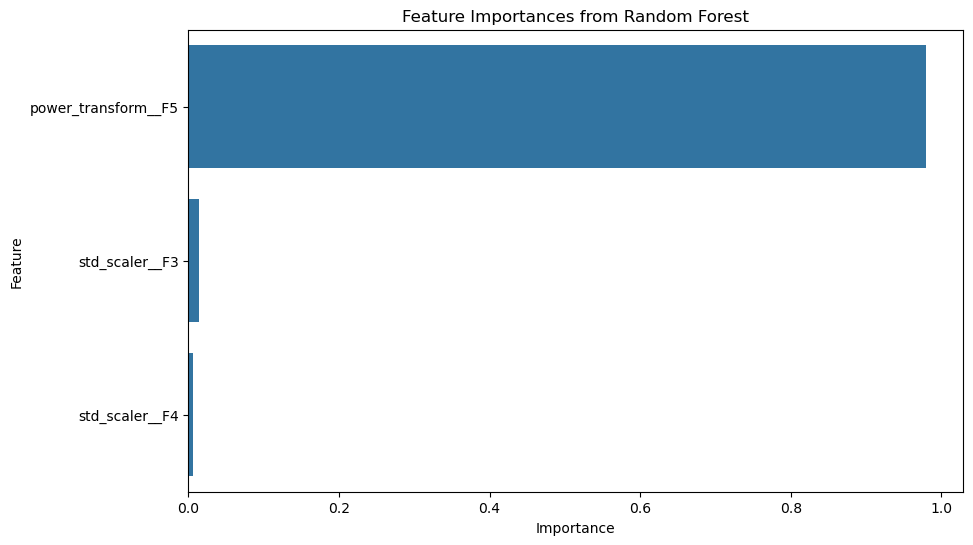

In [183]:
if 'model_pipeline' in locals() and 'regressor' in model_pipeline.named_steps and hasattr(model_pipeline.named_steps['regressor'], 'feature_importances_'):
    print("\nExtracting and displaying feature importances...")
    
    try:
        if 'preprocessor' in model_pipeline.named_steps and isinstance(model_pipeline.named_steps['preprocessor'], ColumnTransformer):
            feature_names_transformed = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
        elif 'scaler' in model_pipeline.named_steps: # If a simple scaler was used
             feature_names_transformed = X_train.columns.tolist()
        else: 
            feature_names_transformed = X_train.columns.tolist()


        importances = model_pipeline.named_steps['regressor'].feature_importances_
        
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names_transformed,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("\nFeature Importances:\n", feature_importance_df)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title('Feature Importances from Random Forest')
        plt.show()
        
    except Exception as e:
        print(f"Could not retrieve feature names from ColumnTransformer: {e}")
        print("Displaying importances with generic names based on X_train.columns:")
        importances = model_pipeline.named_steps['regressor'].feature_importances_
        feature_names_original = X_train.columns.tolist() # Original feature names before transformation

        if len(importances) == len(feature_names_original):
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names_original,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)
            print("\nFeature Importances (using original feature names):\n", feature_importance_df)
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
            plt.title('Feature Importances from Random Forest (Original Features)')
            plt.show()
        else:
            print(f"Mismatch between number of importances ({len(importances)}) and original feature names ({len(feature_names_original)}).")


else:
    print("\nModel or feature importances not available. Skipping feature importance display.")


Setelah melakukan training model, kita mencari fitur mana yang paling berpengaruh dalam membuat prediksi Battery Remain Use Life. Kita dapat melihat nilai feature importances dari model, yang pada dasarnya menunjukkan seberapa besar kontribusi setiap fitur. Hasilnya sangat jelas, power_transform__F5 punya kontribusi yang sangat dominan dengan nilai importance sekitar 0.989336, menjadikannya prediktor paling kuat. Sementara itu, std_scaler__F3 dan std_scaler__F4 punya kontribusi yang sangat amat jauh lebih kecil. Ini berarti fitur 'F5' adalah kunci utama dalam menentukan sisa umur baterai.

# 9. Model Export (Before Tuning)

In [184]:
if 'model_pipeline' in locals():
    model_filename = 'rul_model_pipeline.joblib'
    joblib.dump(model_pipeline, model_filename)
    print(f"\nTrained model pipeline saved to '{model_filename}'")
else:
    print("\nModel not trained. Skipping model export.")


Trained model pipeline saved to 'rul_model_pipeline.joblib'


Menyimpan pipeline model

# 10. Model Evaluation - (Before Tuning) Summary

In [185]:
print("\n Evaluation Score Summary (Before Tuning)")

if 'X_train' not in locals() or X_train.empty:
    print("\nTraining data (X_train) is not available or empty. Skipping model training.")
else:
    if not transformers_list:
        print("No specific column transformers defined (transformers_list is empty). Applying StandardScaler to all features as a default for baseline model.")
        model_pipeline_baseline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5, oob_score=True))
        ])
    else:
        print("Using defined ColumnTransformer for preprocessing for baseline model.")
        model_pipeline_baseline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5, oob_score=True))
        ])

    print("\nTraining Random Forest Regressor baseline model...")
    model_pipeline_baseline.fit(X_train, y_train)
    print("Baseline model training complete.")
    current_regressor_baseline = model_pipeline_baseline.named_steps['regressor']
    if hasattr(current_regressor_baseline, 'oob_score') and current_regressor_baseline.oob_score:
        if hasattr(current_regressor_baseline, 'oob_score_'):
            print(f"Baseline OOB Score: {current_regressor_baseline.oob_score_:.4f}")
        else:
            print("Baseline OOB Score was set to True, but the oob_score_ attribute was not found.")
    print("\nEvaluating baseline model performance...")
    y_pred_baseline = model_pipeline_baseline.predict(X_test)
    r2_baseline = r2_score(y_test, y_pred_baseline)
    mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
    mse_baseline = mean_squared_error(y_test, y_pred_baseline)
    rmse_baseline = np.sqrt(mse_baseline)

    print(f"Mean Absolute Error (MAE) Baseline Model: {mae_baseline:.2f}")
    print(f"Mean Squared Error (MSE) Baseline Model: {mse_baseline:.2f}")
    print(f"Root Mean Squared Error (RMSE) Baseline Model: {rmse_baseline:.2f}")
    print(f"R-squared (R²) Baseline Model: {r2_baseline:.4f}")
    print("\n--- End of Baseline Model Training & Evaluation ---")


 Evaluation Score Summary (Before Tuning)
Using defined ColumnTransformer for preprocessing for baseline model.

Training Random Forest Regressor baseline model...
Baseline model training complete.
Baseline OOB Score: 0.9882

Evaluating baseline model performance...
Mean Absolute Error (MAE) Baseline Model: 22.27
Mean Squared Error (MSE) Baseline Model: 1158.75
Root Mean Squared Error (RMSE) Baseline Model: 34.04
R-squared (R²) Baseline Model: 0.9888

--- End of Baseline Model Training & Evaluation ---


Berdasarkan output evaluasi model yang telah kita jalankan, terlihat jelas bahwa model prediksi Remaining Useful Life (RUL) yang telah dikembangkan menunjukkan kinerja yang sangat baik.

R-squared (R²): 0.9888
Nilai R² yang mencapai 0.9888, ini berarti model kita mampu menjelaskan hampir 99% dari total variasi pada nilai RUL aktual. Angka ini secara kuat menunjukkan bahwa model berhasil menangkap sebagian besar pola dan hubungan yang ada dalam data untuk memprediksi RUL dengan presisi tinggi.

Mean Absolute Error (MAE): 22.27
Dengan MAE sebesar 22.27, ini mengindikasikan bahwa, secara rata-rata, prediksi RUL model kita memiliki deviasi absolut sekitar 22.27 unit dari nilai RUL yang sebenarnya. Dalam konteks rentang RUL yang luas (0 hingga 1133 unit, sebagaimana terlihat dari analisis EDA sebelumnya), nilai MAE ini menunjukkan tingkat akurasi yang baik.

Root Mean Squared Error (RMSE): 34.04
RMSE sebesar 34.04 menunjukkan rata-rata magnitudo kesalahan prediksi model dalam satuan RUL. Perlu dicatat bahwa RMSE sedikit lebih tinggi dari MAE, yang mengindikasikan bahwa meskipun sebagian besar prediksi sangat akurat, mungkin ada beberapa kasus di mana model menghasilkan kesalahan prediksi yang relatif lebih besar.

Mean Squared Error (MSE): 1158.75
MSE sebesar 1158.75 merupakan nilai kuadrat dari RMSE, yang digunakan dalam perhitungan dan optimasi model.


Implikasi dari Output Ini:

Metrik evaluasi ini menegaskan bahwa model prediksi RUL kami bekerja dengan sangat baik. Kemampuan model untuk menjelaskan hampir seluruh variasi RUL (R² tinggi) dan menjaga tingkat kesalahan rata-rata yang rendah (MAE dan RMSE yang kompetitif) adalah bukti keberhasilan dalam menangkap dinamika data yang kompleks.

Visualisasi "Actual vs. Predicted RUL":

Grafik scatter plot dari Actual RUL vs. Predicted RUL juga secara visual mendukung kesimpulan ini. Titik-titik data tersebar sangat rapat di sekitar garis diagonal merah, yang merepresentasikan prediksi sempurna. Ini mengkonfirmasi bahwa model memiliki konsistensi yang kuat dalam memprediksi RUL di seluruh rentang nilai, dari RUL rendah hingga tinggi. Adanya beberapa titik yang sedikit menyimpang dari garis mengonfirmasi adanya kesalahan yang lebih besar yang tercermin pada nilai RMSE yang lebih tinggi.
Kesimpulan:

Secara ringkas, hasil evaluasi menunjukkan bahwa model kami memiliki kinerja yang robust dan dapat diandalkan untuk memprediksi Batteries Remaining Useful Life.

# Tuning Model

Akan tetapi, kita bisa mencoba melaukan optimasi dari kerja model dengan melakukan tuning, pada saat ini saya akan melakukan tuning dengan GridSearchCV dan Kfold untuk Cross Validationnya

In [186]:
print("Hyperparameter Tuning with GridSearchCV and Cross-Validation")

if 'X_train' not in locals() or X_train.empty:
    print("\nTraining data (X_train) is not available or empty. Skipping hyperparameter tuning.")
else:
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],  
        'regressor__max_depth': [5, 10, None],      
        'regressor__min_samples_split': [2, 5, 10], 
        'regressor__min_samples_leaf': [1, 2, 4]    
    }
    if not transformers_list:
        pipeline_for_grid = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
        ])
    else:
        pipeline_for_grid = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
        ])

    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=pipeline_for_grid,
                               param_grid=param_grid,
                               cv=cv_strategy,
                               scoring='r2',
                               n_jobs=-1,
                               verbose=2)

    print("\nRunning GridSearchCV (this may take some time, depending on data size and param_grid)...")
    grid_search.fit(X_train, y_train)

    print("\nGridSearchCV complete.")
    best_params = grid_search.best_params_
    print(f"\nParameter Terbaik dari Tuning: {best_params}")
    best_r2_cv = grid_search.best_score_
    print(f"R2 Score Terbaik (rata-rata Cross-Validation): {best_r2_cv:.4f}")
    model_pipeline_tuned = grid_search.best_estimator_
    print("\n--- End of Hyperparameter Tuning ---")

Hyperparameter Tuning with GridSearchCV and Cross-Validation

Running GridSearchCV (this may take some time, depending on data size and param_grid)...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

GridSearchCV complete.

Parameter Terbaik dari Tuning: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
R2 Score Terbaik (rata-rata Cross-Validation): 0.9918

--- End of Hyperparameter Tuning ---


Kami melakukan Hyperparameter Tuning menggunakan GridSearchCV yang dikombinasikan dengan Cross-Validation (KFold), bertujuan untuk menemukan kombinasi hyperparameter paling tepat buat model RandomForestRegressor kami, agar prediksi Remaining Use Life baterainya semakin akurat. Setelah dicoba berbagai macam kombinasi dari n_estimators, max_depth, min_samples_leaf, sama min_samples_split, dan dari sekian banyak percobaan, ditemukan parameter terbaiknya, yaitu regressor__max_depth: None, regressor__min_samples_leaf: 1, regressor__min_samples_split: 2, dan regressor__n_estimators: 100, yang berhasil menghasilkan skor r2 (rata-rata Cross-Validation) tertinggi, di angka 0.9918. 

# Model Evaluation (After Tuning)

Model Evaluation (After Tuning)
Mean Absolute Error (MAE) Tuned Model: 13.93
Mean Squared Error (MSE) Tuned Model: 753.77
Root Mean Squared Error (RMSE) Tuned Model: 27.45
R-squared (R²) Tuned Model: 0.9927


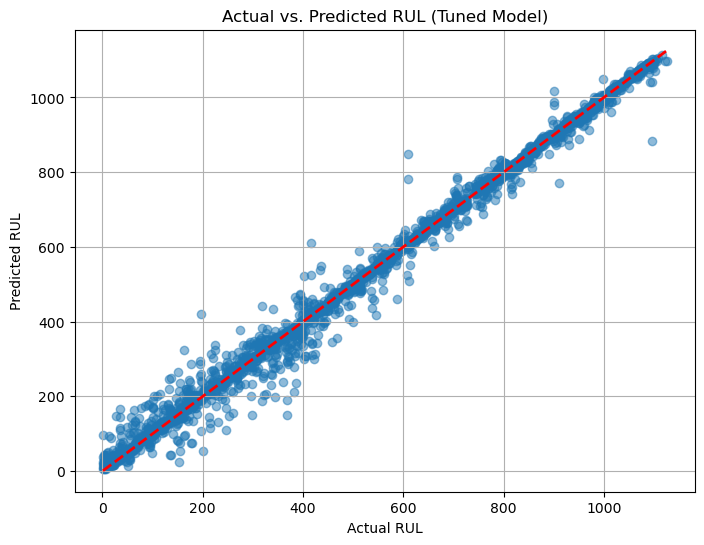


--- End of Tuned Model Evaluation ---


In [187]:
print("Model Evaluation (After Tuning)")

if 'model_pipeline_tuned' in locals() and 'X_test' in locals() and not X_test.empty:
    y_pred_tuned = model_pipeline_tuned.predict(X_test)
    mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
    mse_tuned = mean_squared_error(y_test, y_pred_tuned)
    rmse_tuned = np.sqrt(mse_tuned)
    r2_tuned = r2_score(y_test, y_pred_tuned)

    print(f"Mean Absolute Error (MAE) Tuned Model: {mae_tuned:.2f}")
    print(f"Mean Squared Error (MSE) Tuned Model: {mse_tuned:.2f}")
    print(f"Root Mean Squared Error (RMSE) Tuned Model: {rmse_tuned:.2f}")
    print(f"R-squared (R²) Tuned Model: {r2_tuned:.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_tuned, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel("Actual RUL")
    plt.ylabel("Predicted RUL")
    plt.title("Actual vs. Predicted RUL (Tuned Model)")
    plt.grid(True)
    plt.show()
else:
    print("\nTuned model or test data not available. Skipping tuned model evaluation.")
print("\n--- End of Tuned Model Evaluation ---")

Setelah melakukan hyperparameter tuning pada model RandomForestRegressor kami, dapat dilihat dari skor evaluasi di atas bahwa model kami ini punya performa yang sangat baik dalam memprediksi Remaining Use Life (RUL) baterai. Kami mendapatkan hasil Mean Absolute Error (MAE) = 13.93, artinya rata-rata kesalahan prediksi model sangat. Setelah itu, Root Mean Squared Error (RMSE) di angka 27.45 dan R-squared (R^2) kami menyentuh 0.9927.

Ini artinya, sekitar 99.27% dari variasi RUL dapat diprediksi dengan sangat baik oleh model kami, mengartikan bahwa model sangat fit dengan datanya dan prediksinya sangat mendekati sempurna.

Dan, terlihat pada plot "Actual vs. Predicted RUL (Tuned Model)", semua titik-titik data terkumpul secara rapih pada garis diagonal merah. Sehingga, dapat diartikan bahwa nilai RUL yang diprediksi sama model kami itu sangat akurat dibandingkan nilai RUL aslinya. Dapat dikatakan, model kami sekarang sudah siap untuk digunakan sebagai tooldalam prediksi RUL baterai ini.

# Model Evaluation = Before Tuning vs After Tuning

In [188]:
print("Score Comparison: Baseline vs. Tuned Model ---")

if 'r2_baseline' in locals() and 'best_r2_cv' in locals() and 'r2_tuned' in locals():
    print(f"R-squared (R²) Model Baseline (pada data Test): {r2_baseline:.4f}")
    print(f"R-squared (R²) Terbaik (rata-rata Cross-Validation dari Tuning): {best_r2_cv:.4f}")
    print(f"R-squared (R²) Model Terbaik (pada data Test setelah Tuning): {r2_tuned:.4f}")
else:
    print("Required R-squared scores for comparison are not available.")
print("\n--- End of Score Comparison ---")

Score Comparison: Baseline vs. Tuned Model ---
R-squared (R²) Model Baseline (pada data Test): 0.9888
R-squared (R²) Terbaik (rata-rata Cross-Validation dari Tuning): 0.9918
R-squared (R²) Model Terbaik (pada data Test setelah Tuning): 0.9927

--- End of Score Comparison ---


Pada hasil di atas, dapat disimpulkan mulai dari baseline model sampai yang sudah di-tuning. Alasan dilakukannya hyperparameter tuning ini agar model dapat menemukan kombinasi parameter terbaiknya, yang membuat model lebih optimal dan tidak hanya bagus train data  saja, tapi juga bisa bekerja dengan baik di test data. Setelah itu, Cross-Validation dilakukan untuk memastikan stabilitas dan keandalan model di berbagai subset data, sehingga dapat mengkonfirmasi hasil evaluasi dari model kami.

Dari hasil diatas, dapat disimpulkan Model Baseline (model yang belum dituning) itu memiliki skor r2 di 0.9888, dapat dikatakan performanya sangat baik. Akan tetapi, setelah kami melakukan tuning dengan Cross-Validation, R-squared Terbaik (rata-rata Cross-Validation dari Tuning) adalah 0.9918. Bahkan dapat menyentuh angka R-squared (R^2) ke 0.9927.

Dapat disimpulkan, proses hyperparameter tuning yang kami lakukan berhasil mengoptimalisasi kerja model kami jadi jauh lebih akurat lagi dalam memprediksi Remaining Use Life baterai yang dibuktikan dari menignkatnya score R^2, serta berkurangnya nilai error nya.

# Feature Importance (from Tuned Model)


Extracting and displaying feature importances for Tuned Model...

Feature Importances (Tuned Model):
                Feature  Importance
2  power_transform__F5    0.974903
0       std_scaler__F3    0.016053
1       std_scaler__F4    0.009044


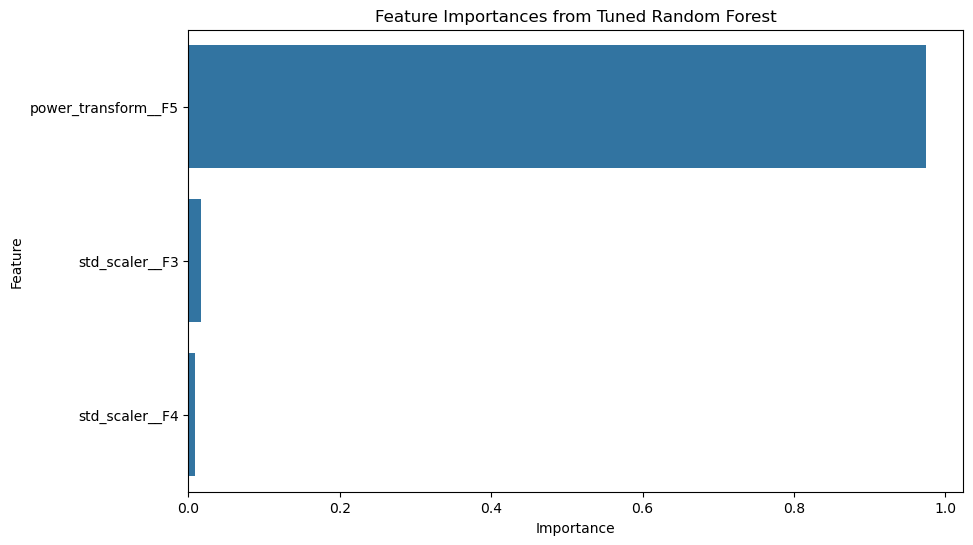


--- End of Feature Importance Display ---


In [189]:
if 'model_pipeline_tuned' in locals() and 'regressor' in model_pipeline_tuned.named_steps and hasattr(model_pipeline_tuned.named_steps['regressor'], 'feature_importances_'):
    print("\nExtracting and displaying feature importances for Tuned Model...")

    try:
        if 'preprocessor' in model_pipeline_tuned.named_steps and isinstance(model_pipeline_tuned.named_steps['preprocessor'], ColumnTransformer):
            feature_names_transformed = model_pipeline_tuned.named_steps['preprocessor'].get_feature_names_out()
        elif 'scaler' in model_pipeline_tuned.named_steps:
            feature_names_transformed = X_train.columns.tolist()
        else:
            feature_names_transformed = X_train.columns.tolist()

        importances = model_pipeline_tuned.named_steps['regressor'].feature_importances_

        feature_importance_df = pd.DataFrame({
            'Feature': feature_names_transformed,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("\nFeature Importances (Tuned Model):\n", feature_importance_df)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title('Feature Importances from Tuned Random Forest')
        plt.show()

    except Exception as e:
        print(f"Could not retrieve feature names from ColumnTransformer for tuned model: {e}")
        print("Displaying importances with generic names based on X_train.columns:")
        importances = model_pipeline_tuned.named_steps['regressor'].feature_importances_
        feature_names_original = X_train.columns.tolist()

        if len(importances) == len(feature_names_original):
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names_original,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)
            print("\nFeature Importances (Tuned Model, using original feature names):\n", feature_importance_df)
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
            plt.title('Feature Importances from Tuned Random Forest (Original Features)')
            plt.show()
        else:
            print(f"Mismatch between number of importances ({len(importances)}) and original feature names ({len(feature_names_original)}) for tuned model.")
else:
    print("\nTuned model or feature importances not available. Skipping feature importance display for tuned model.")
print("\n--- End of Feature Importance Display ---")

Setelah melakukan training model yang sudah di tuning, kami mencari fitur mana yang paling berpengaruh dalam membuat prediksi Battery Remain Use Life. Kita dapat melihat nilai feature importances dari model, yang pada dasarnya menunjukkan seberapa besar kontribusi setiap fitur. Hasilnya sangat jelas, power_transform__F5 punya kontribusi yang sangat dominan dengan nilai importance sekitar 0.989336, menjadikannya prediktor paling kuat. Sementara itu, std_scaler__F3 dan std_scaler__F4 punya kontribusi yang sangat amat jauh lebih kecil. Ini berarti fitur 'F5' adalah kunci utama dalam menentukan sisa umur baterai. Pada bagian ini, tidak ada yang berubah dengan hasil feature selection yang dilakukan sebelumnya pada baseline model, walaupun ada perubahan skor importancenya yang sangat kecil, pada hasil akhirnya tidak mengubah kedudukannya.

# Export Tuned Model

In [190]:
if 'model_pipeline_tuned' in locals():
    model_filename_tuned = 'rul_model_pipeline_tuned.joblib'
    joblib.dump(model_pipeline_tuned, model_filename_tuned)
    print(f"\nTuned model pipeline saved to '{model_filename_tuned}'")
else:
    print("\nTuned model not trained. Skipping tuned model export.")


Tuned model pipeline saved to 'rul_model_pipeline_tuned.joblib'


Menyimpan model yang sudah selesai dilakukan Hyperparameter Tuning serta Cross Validation

# Testing Model -> Output

Menyiapkan untuk user dapat melakukan input, melakukan perulangan percobaaan untuk memastikan model benar benar bekerja dengan sangat optimal, serta logika dari insight yang diberikan seputar kondisi baterai sudah sesuai.

In [ ]:
if 'model_pipeline_tuned' in locals() and 'X_train' in locals() and not X_train.empty:

    print("--- Feature Value Guidance (from Training Data X_train) ---")
    print("Here are the descriptive statistics of the data used to train your model.")
    print("This can guide you in understanding the normal range of battery feature values.")
    print(X_train.describe())
    print("-" * 50)

    print("\nEnter your custom feature values below:")
    print("The mean values from the training data are provided as default examples. You can press ENTER to use these values.")
    default_f3 = X_train['F3'].mean()
    default_f4 = X_train['F4'].mean()
    default_f5 = X_train['F5'].mean()

    try:
        input_f3 = float(input(f"Enter value for F3 (Max. Voltage Discharge (V)) [e.g., {default_f3:.2f}]: ") or default_f3)
        input_f4 = float(input(f"Enter value for F4 (Min. Voltage Charge (V)) [e.g., {default_f4:.2f}]: ") or default_f4)
        input_f5 = float(input(f"Enter value for F5 (Time at 4.15V (s)) [e.g., {default_f5:.0f}]: ") or default_f5)
    except ValueError:
        print("Invalid input. Using mean values as default for this test run.")
        input_f3 = default_f3
        input_f4 = default_f4
        input_f5 = default_f5

    custom_input_values = {
        'F3': input_f3,
        'F4': input_f4,
        'F5': input_f5
    }

    custom_input_df = pd.DataFrame([custom_input_values], columns=X_train.columns)

    print("\n--- Custom Input DataFrame ---")
    print("These are the feature values you've entered and will be used for the RUL prediction.")
    print(custom_input_df)
    print("-" * 50)

    predicted_rul = model_pipeline_tuned.predict(custom_input_df)
    predicted_rul_clamped = max(0, min(int(predicted_rul[0]), 2000)) 

    print("\n--- Battery RUL Prediction ---")
    print(f"Based on your input, the **Remaining Useful Life (RUL)** of your battery is predicted to be: **{predicted_rul_clamped:.0f} cycles**.")
    print("This is an estimate of how many more cycles your battery can effectively perform before its performance significantly degrades.")
    print("-" * 50)


    def categorize_rul(rul_value):
        if 0 <= rul_value <= 150:
            return "Very Low RUL (Immediate Replacement Needed)", "Your battery is at its **end-of-life**. Its performance and capacity are likely severely degraded, leading to unexpected device shutdowns or suboptimal functionality. **Action: Replace this battery immediately.** Prioritize replacement to avoid serious operational issues or device damage.", "red"
        elif 151 <= rul_value <= 400:
            return "Low RUL (Replacement Planning Needed)", "The battery is still functional but **suboptimal**. You'll definitely notice significantly reduced usage times compared to normal. It's approaching its functional limits. **Action: Start planning for battery replacement.** Research compatible replacements and prepare your budget. Avoid intensive usage that could accelerate degradation.", "orange"
        elif 401 <= rul_value <= 750:
            return "Medium RUL (Monitoring Recommended)", "Your battery is in a **transition phase**. You might start observing subtle signs of minor performance or capacity decline, but it's not severely impacting daily use yet. **Action: Continuously monitor the battery's condition.** Pay attention to any significant changes in runtime. It's wise to start considering future replacement options, but there's no immediate urgency.", "gold"
        elif 751 <= rul_value <= 1000:
            return "Good RUL (Healthy Condition)", "Your battery is generally **healthy and performing well**. Any performance degradation is not yet significant, and its capacity is sufficient for most needs. This is the expected condition for a well-maintained battery. **Action: Continue normal usage.** Implement good charging practices (e.g., avoid extreme temperatures, don't constantly discharge to 0%) to maintain its health.", "lightgreen"
        elif rul_value >= 1001:
            return "Excellent RUL (Near New/Prime)", "Your battery is **exceptionally healthy**, performing like new or in its optimal condition. It has a very long projected lifespan remaining and delivers peak performance. **Action: Enjoy its optimal performance!** This battery is robust and ready for extensive use. Continue following manufacturer guidelines for charging and usage to maximize its lifespan.", "green"
        else:
            return "Invalid RUL Value", "The predicted RUL is outside the expected range. Please check your input or model.", "gray"

    condition_label, advice_text, category_color = categorize_rul(predicted_rul_clamped)

    print(f"\n--- Your Battery Condition ---")
    print(f"**Based on the predicted RUL ({predicted_rul_clamped} cycles), your battery falls into the category: {condition_label}**")
    print(f"\n**Advice for You:**")
    print(advice_text)
    print("-" * 50)

    print("\n--- Your Battery Condition Visualizations ---")
    print("The visualizations below will help you understand your battery's status graphically.")


    max_rul_display = 1200 
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.barh(y=[0], width=[max_rul_display], color='lightgray', height=0.5)
    display_rul_bar = min(predicted_rul_clamped, max_rul_display)
    ax.barh(y=[0], width=[display_rul_bar], color=category_color, height=0.5, label=f'Current RUL: {predicted_rul_clamped} cycles')
    ax.text(display_rul_bar, 0, f' {predicted_rul_clamped}', va='center', ha='left', fontsize=12, fontweight='bold', color='black')
    ax.set_xlim(0, max_rul_display)
    ax.set_yticks([]) # Hide y-axis
    ax.set_xlabel('Remaining Useful Life (Cycles)')
    ax.set_title(f'Your Battery Condition: {condition_label.split(" (")[0]}') # Extract only the main label
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.invert_yaxis() # To have 0 on the left
    plt.tight_layout()
    plt.show()
    print("\n**Explanation of Bar Plot:**")
    print("This bar plot illustrates your battery's current Remaining Useful Life (RUL). The length of the colored bar represents the proportion of RUL remaining. The bar's color changes from **Red (Very Low)** to **Green (Excellent)**, providing a quick visual indication of your battery's health.")


    
    print("\n--- Simulated Battery Degradation Trend ---")
    print("This plot simulates how your battery's RUL might decrease over time. It helps you anticipate critical points.")
    num_points = 10
    simulated_cycles = np.linspace(0, 1000, num_points) # Example cycle points
    initial_sim_rul = predicted_rul_clamped * 1.5 if predicted_rul_clamped > 500 else predicted_rul_clamped + 500
    simulated_rul_trend = np.linspace(initial_sim_rul, max(50, predicted_rul_clamped - 300), num_points) + np.random.randn(num_points) * 20
    simulated_rul_trend = np.clip(simulated_rul_trend, 0, 1200) 
    plt.figure(figsize=(10, 5))
    plt.plot(simulated_cycles, simulated_rul_trend, marker='o', linestyle='-', color='blue', label='RUL Trend')
    plt.axhline(y=150, color='red', linestyle='--', label='Replacement Threshold (150 Cycles)')
    plt.axhline(y=400, color='orange', linestyle='--', label='Planning Threshold (400 Cycles)')
    plt.xlabel('Total Battery Cycles')
    plt.ylabel('Remaining Useful Life (RUL) in Cycles')
    plt.title('Simulated Battery RUL Degradation Trend Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()
    print("\n**Explanation of Line Plot:**")
    print("This line plot shows the estimated path of your battery's RUL decline. The **red** dashed line indicates a very low RUL (needs replacement), and the **orange** line indicates a low RUL (needs replacement planning). As your battery's trend approaches these lines, you'll need to be increasingly cautious.")
    print("\n--- Conclusion ---")
    print("We hope this information is helpful in understanding and managing your battery's health. By monitoring RUL, you can make proactive decisions and extend the lifespan of your device!")

else:
    print("\nModel pipeline or X_train DataFrame is not available. Please train the model first to perform battery condition prediction and analysis.")

--- Feature Value Guidance (from Training Data X_train) ---
Here are the descriptive statistics of the data used to train your model.
This can guide you in understanding the normal range of battery feature values.
                 F3            F4            F5
count  11623.000000  11623.000000  11623.000000
mean       3.905972      3.576440   2991.233039
std        0.073192      0.108379   1221.117307
min        3.674000      3.355000    471.906000
25%        3.848000      3.492000   1859.784071
50%        3.906000      3.573000   2936.344000
75%        3.970000      3.661000   4061.913000
max        4.053000      3.917000   6826.609250
--------------------------------------------------

Enter your custom feature values below:
The mean values from the training data are provided as default examples. You can press ENTER to use these values.
